# SIR model of an epidemic

Consider $s(t)$ the density of susceptible/healthy people in a population at time $t$, $i(t)$ the density of infected people who are still infectious and $r(t)$ the recovered/removed, i.e. the people who pass away or get healthy and can be considered immunized.

Let's make the most simple assumptions about the dynamics of the densities. Our model shall be coverned by two parameters: the transmission rate $\beta > 0$ and the average duration of the disease $\Delta > 0$. The rate of change of $s(t)$ is given by

$$  \dot{s}(t) = -\beta s(t) i(t) $$

This choice reflects that in order for a healthy person to get infected there have to be healthy people meeting infected people. $\beta$ measures the exposure, i.e. all the complicated stuff like how hygienic the exchange is or how socially distant.

The change of infected people has two parts. First, susceptible people get infected. But after some average time $\Delta$ these people get removed, either by surviving the disease or deceasing. Hence

$$
\begin{aligned}
\dot{i}(t) &= \beta s(t) i(t) -  \frac{1}{\Delta} i(t)
\end{aligned}
$$

The removed population increases accordingly 
$$
\begin{aligned}
\dot{r}(t) &= \frac{1}{\Delta} i(t)
\end{aligned}
$$

In some sense the infectious state $i$ is only a transition state from susceptible to removed
$$
s(t) \underset{\beta s(t) i(t)}{\longrightarrow} i(t)\underset{\frac{1}{\Delta} i(t)}{\longrightarrow} r(t)
$$

where $\Delta$ is the time spend in the transition. Obviously, we demand that the entire population is either susceptible, infected or removed:

$$ s(t) + i(t) + r(t) = 1$$

This is convenient. We only need to find two of the densities and the third will follow. However, we will try to compute all three. As starting conditions we assume that some small fraction $\epsilon$ of the population got infected, while all others are healthy

$$
\begin{aligned}
i(0) &= \epsilon \\
s(0) &= 1 - \epsilon \\
r(0) &= 0
\end{aligned}
$$

Now all we need to do is to solve the following set of integral equations

$$
\begin{aligned}
i(t) &= \epsilon + \int_0^t \beta s(t') i(t') - \frac{1}{\Delta} i(t')  \ dt' \\
s(t) &= 1 - \epsilon - \beta \int_0^t s(t') i(t') dt' \\
r(t) &= \frac{1}{\Delta} \int_0^t i(t') dt' 
\end{aligned}$$

Easy peasy, but as far as I know there is no analytic solutions to this and I don't think I will figure it out right now either. I'll solve this numerically.

In [1]:
from itertools import product
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# infectious period in days
deltas = np.arange(1., 20., 1/6)

# transmission rate in arbitrary units
betas = np.arange(0.005, 0.3, 0.003)

# fraction of population initially infected
EPS = 1e-5

# step size for numerical integration
STEP = 1e-3

# days to simulate
T = 4*365.

# time axis in units of STEP
time = np.arange(int(np.ceil(T/STEP)))

# if True -> load data from disk
# previous simulation must have identical parameters
LOAD_FROM_DISK = True

# output (or input) directory
OUTDIR = "./SIR_simulation_LONG"

In [3]:
def integrate(beta, delta):
    
    i = np.zeros(len(time))
    s = np.zeros(len(time))
    r = np.zeros(len(time))
    
    i[0] = EPS
    s[0] = 1-EPS
    r[0] = 0

    # naive integrator
    for t in time:

        delta_i = beta*s[t]*i[t] - i[t]/delta 
        delta_s = -s[t]*i[t]*beta
        delta_r = i[t]/delta
        
        if t != time[-1]:
            i[t+1] = i[t] + STEP*delta_i
            s[t+1] = s[t] + STEP*delta_s
            r[t+1] = r[t] + STEP*delta_r
    
    # dump results to disk
    i_file = f"{OUTDIR}/i_beta={beta}_delta={delta}.npy"
    s_file = f"{OUTDIR}/s_beta={beta}_delta={delta}.npy"
    r_file = f"{OUTDIR}/r_beta={beta}_delta={delta}.npy"
    
    np.save(i_file, i)
    np.save(s_file, s)
    np.save(r_file, r)
    
    # return file names
    return i_file, s_file, r_file

If we ran a simulation already, we can just load the data. Otherwise we spawn several processes to make use of all CPU-cores (6*2 in this case) and we run 2 processes per core to make sure they are always busy.

In [4]:
if LOAD_FROM_DISK:
    results = []
    for beta, delta in product(betas, deltas):
        results.append((f"{OUTDIR}/i_beta={beta}_delta={delta}.npy",
                        f"{OUTDIR}/s_beta={beta}_delta={delta}.npy",
                        f"{OUTDIR}/r_beta={beta}_delta={delta}.npy"))
else:
    with mp.Pool(processes=24) as pool:
        results = pool.starmap(integrate, product(betas, deltas))

First, let's look at the curves of how the populations develop over time for a few exemplary choices of $\beta$ and $\Delta$.

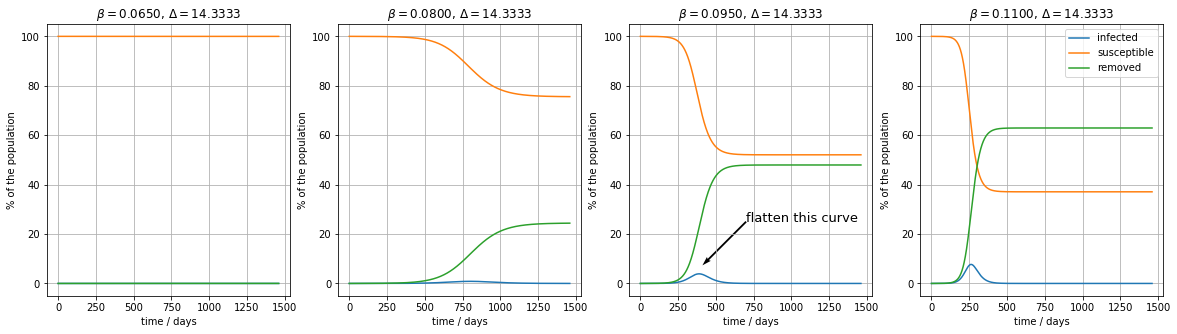

In [6]:
sample_idx = [(20, 80), (25, 80), (30, 80), (35, 80)]

plt.figure(figsize=(20,5))

for k in range(len(sample_idx)):
    
    i = sample_idx[k][0]
    j = sample_idx[k][1]
    
    # mp.Pool should return results in the order of product(betas, deltas)
    infected = np.load(results[len(deltas)*i + j][0])
    susceptible = np.load(results[len(deltas)*i + j][1])
    removed = np.load(results[len(deltas)*i + j][2])

    plt.subplot("14"+str(k+1))
    plt.plot(time*STEP, 100*infected, label="infected")
    plt.plot(time*STEP, 100*susceptible, label="susceptible")
    plt.plot(time*STEP, 100*removed, label="removed")
    plt.grid()
    
    if k == len(sample_idx)-1:
        plt.legend()
        
    if k == 2:
        plt.quiver(700, 25, -.9, -.9, scale=5)
        plt.text(700, 25, "flatten this curve", fontsize=13)
    
    plt.xlabel("time / days")
    plt.ylabel("% of the population")
    plt.title(fr"$\beta = {betas[i]:.4f}$, $\Delta = {deltas[j]:.4f}$")

In these graphs we assume that the average patient is infectious for about two weeks. The blue curve of infectious people is the curve that is to be flattened. Interestingly it seems as if a flattening of the curve by decreasing $\beta$ not only means that fewer people are sick at the same time, but also that fewer people will get sick in total. 

Let's look at the total infections at the end of the simulation for various $\beta$ and $\Delta$.

In [7]:
total_infections = np.zeros([len(betas), len(deltas)])

for i in range(len(betas)):
    for j in range(len(deltas)):
        
        susceptible = np.load(results[len(deltas)*i + j][1])
        
        # compute fraction of people who got infected in total after time t
        total_infections_t = 1 - susceptible
        
        # how many people got infected overall
        total_infections[i, j] = total_infections_t[-1]

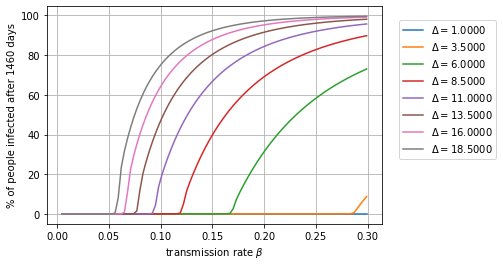

In [8]:
for i in range(0, len(deltas), 15):
    plt.plot(betas, 100*total_infections[:, i], label=rf"$\Delta = {deltas[i]:.4f}$")

plt.grid()
plt.xlabel(rf"transmission rate $\beta$")
plt.ylabel(f"% of people infected after {int(T)} days")
plt.legend(loc=(1.05, .3))

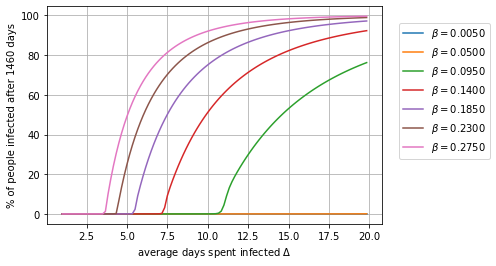

In [9]:
for i in range(0, len(betas), 15):
    plt.plot(deltas, 100*total_infections[i, :], label=rf"$\beta = {betas[i]:.4f}$")

plt.grid()
plt.xlabel(rf"average days spent infected $\Delta$")
plt.ylabel(f"% of people infected after {int(T)} days")
plt.legend(loc=(1.05, .3))

This looks like a continuous phase transition. Let's extract the critical rate $\beta_c(\Delta)$ so that we can draw a phase diagram in the $\beta$-$\Delta$-plane. 

In [10]:
def extract_beta_c(F, T):
    
    # quick-n-dirty 1st derivative
    dF = (F[:-1] - F[1:]) / (T[1:] - T[:-1])
    
    # quick-n-dirty 2nd derivative
    ddF = (dF[:-1] - dF[1:]) / (T[2:] - T[:-2])
    
    # quick-n-dirty critcal transmission rate -> look for divergence
    ic = np.where(np.abs(ddF) == np.abs(ddF).max())[0][0]
    
    if ic >= len(dF)-2: # phase transition probabliy wasn't measured
        return np.inf
    else:
        return T[ic]

In [11]:
beta_c = np.zeros(len(deltas))
for i in range(len(deltas)):
    beta_c[i] = extract_beta_c(total_infections[:, i], betas)

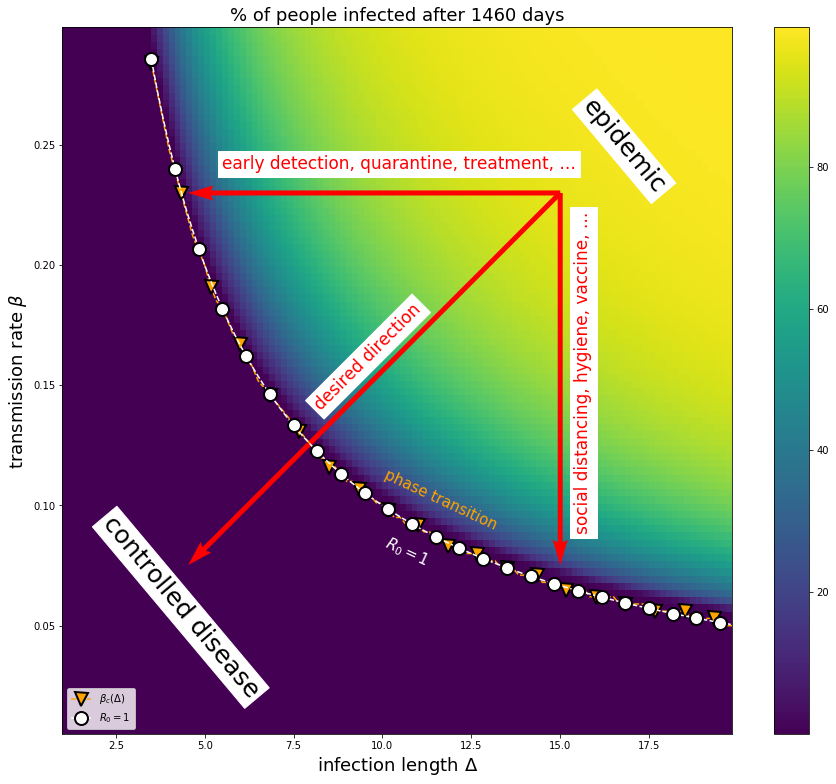

In [12]:
plt.figure(figsize=(15, 13))
X, Y = np.meshgrid(deltas, betas)

plt.pcolor(X, Y, 100*total_infections)
plt.colorbar()

plt.text(8., 0.14, "desired direction", color="red", fontsize=17, rotation=45, backgroundcolor="white")
plt.quiver(15, .23, -1, -1, color="red", scale=1.8)

plt.text(15.4, .09, "social distancing, hygiene, vaccine, ...", color="red", fontsize=17, rotation=90, backgroundcolor="white")
plt.quiver(15, .23, 0, -1, color="red", scale=1.8)

plt.text(5.5, .24, "early detection, quarantine, treatment, ...", color="red", fontsize=17, backgroundcolor="white")
plt.quiver(15, .23, -1, 0, color="red", scale=1.8)

plt.text(15.5, .23, "epidemic", color="black", fontsize=25, rotation=-50, backgroundcolor="white")
plt.text(2, .02, "controlled disease", color="black", fontsize=25, rotation=-50, backgroundcolor="white")

plt.title(f"% of people infected after {int(T)} days", fontsize=18)
plt.xlabel(rf"infection length $\Delta$", fontsize=18)
plt.ylabel(rf"transmission rate $\beta$", fontsize=18)

plt.plot(deltas, beta_c, "v--", c="orange",
         markevery=5, markersize=13, markeredgewidth=2,
         markeredgecolor="black", label=r"$\beta_c(\Delta)$")

plt.text(10, 0.09, "phase transition", c="orange", rotation=-25, fontsize=15)

R_c_beta = 1/deltas
plt.plot(deltas[R_c_beta < betas.max()], R_c_beta[R_c_beta < betas.max()], "o--", c="white",
         markevery=4, markersize=13, markeredgewidth=2,
         markeredgecolor="black",label=r"$R_0 = 1$")

plt.text(10, 0.075, rf"$R_0 = 1$", c="white", rotation=-25, fontsize=15)
plt.legend(loc=3)

## Basic reproduction number $R_0$

The relevant quantity of SIR models is the basic reproduction number $R_0$. $R_0$ can be derived via the following thought. We would like to know under which circumstances $i(t)$ will decrease, i.e.

$$
\dot{i}(t) = \beta s(t) i(t) -  \frac{1}{\Delta} i(t) < 0
$$

Re-arranging this expression we get

$$
\beta\Delta < \frac{1}{s(t)}
$$

This means, if the fraction of susceptible people $s(t)$ is smaller than $\frac{1}{\beta\Delta}$, then the fraction of infected people will decrease. $s(t)$ is maximal $s(t=0)$, which is pretty close to 1, so we can say that

$$
\begin{align}
\beta\Delta &< 1 \rightarrow \text{disease will disappear} \\
\beta\Delta &> 1 \rightarrow \text{disease will break out}
\end{align}
$$

$\beta \Delta$ is also known as $R_0$. Hence $R_0 = 1$ defines the border between outbreak and a controlled disease. It can be plotted as a line in the $\beta$-$\Delta$-plane according to

$$
\beta(\Delta) = \frac{1}{\Delta}
$$

If we plot the $R_0 = 1$ line in the phase space, we find that it coincides quite well with the critical line of the continuous phase transition.

**Addendum:** The length of the simulation of 4 years was chosen based on this. For shorter simulations, there was always a difference between the phase transition and $R_0=1$ in that the phase transition occured at $R_0 > 1$. At first I was a bit confused by this, but it turned out that this difference was caused by the simulations being to short and not capturing the outbreak of the epidemic. Hence I increased $T$ and found that the two lines coincide eventually. I guess for the future it might be interesting to figure out how the choise of $\beta$ and $\Delta$ influences the time scale of the epidemic.

## Learnings

In this simple model we find that

1) "Flatten the curve" not only decreases the infections at any point in time, but results in fewer total infections. Although this seems to be a small effect because of the second learning.

2) In terms of the basic reproduciton number $R_0$, the total rate of infection undergoes a phase transition. It's almost a black-or-white-type of situation. If $R_0 < 1$ the disease is easily controlled. If $R_0 > 1$, a large percentage of the population will get infected, without much nuance in between these two phases. 

Of course, this is only a rough aproximation of the true process, but it already captures relevant properties. In a next step, the model could be more complex, e.g. by modelling healed and deceased as separate states with separate transition rates from the infected state. Additionally, the mortality could be considered a function of $i(t)$, as more infected people mean worse care at the hospitals and hence higher mortality.